In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd

from astropy.io import fits
import astropy.units as u

import scipy
from scipy.constants import e as elem
from scipy.integrate import quad 
from scipy.optimize import curve_fit
from scipy import signal 
from scipy import stats
from uncertainties import ufloat
from uncertainties import unumpy as unp

from random import randint
from random import uniform 

from collections import OrderedDict

from ebltable.tau_from_model import OptDepth
tau =  OptDepth.readmodel(model = 'dominguez')

from Gilmore_simulation import calculatesignificance,calculaterate
from Gilmore_simulation import calculaterate_GBM
from Gilmore_simulation import plot_simulation, integrate_background

from spectra_LAT import plot_Flux_Energy_LAT 
from spectra_LAT import make_DF_from_LGRB
from spectra import make_DF_from_GBM, make_DF_from_BATSE

from Sensitivity import plot_Sens
from Sensitivity import plot_ctools_Crab, plot_HEGRA_Crab

from Fitting_models import Plaw_LAT
from Lightcurve import fit_LC_simple_Gaussian,fit_LC_small_Gaussian, save_LAT_txt,Gauss, exp, reset_txt
from Lightcurve import rescale_x,rescale_y

tugreen = '#73ae14'
cmap = plt.cm.get_cmap('viridis')
viridis10 = cmap(0.1)
viridis9 = cmap(0.2)
viridis8 = cmap(0.28)
viridis7 = cmap(0.35)
viridis6 = cmap(0.42)
viridis5 = cmap(0.5)
viridis4 = cmap(0.6)
viridis3= cmap(0.7)
viridis2 = cmap(0.82)
viridis1 = cmap(0.9)
viridis0 = cmap(0.98)

import imp

## Spectrum 

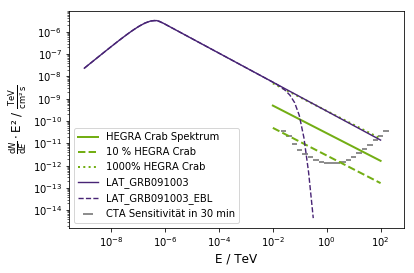

In [6]:
plot_Sens('Tev','binwise','dimgray')
plot_HEGRA_Crab(-2,2,True,tugreen)
plot_Flux_Energy_LAT('GRB090926',-9,2,True,False,0,viridis10)
plot_Flux_Energy_LAT('GRB090926',-9,-0.5,True,True,2.14,viridis10)
plt.savefig('Plots_DE/GRB_Example.pdf',bbox_inches = 'tight')
#plt.savefig('Plots_DE/jpeg/GRB_Example.jpeg',bbox_inches = 'tight')
plt.clf()
plot_Sens('Tev','binwise','dimgray')
plot_HEGRA_Crab(-2,2,True,tugreen)
plot_Flux_Energy_LAT('GRB091003',-9,2,True,False,0,viridis10)
plot_Flux_Energy_LAT('GRB091003',-9,-0.5,True,True,2.14,viridis10)
#plt.savefig('Plots_DE/GRB_Example2.pdf',bbox_inches = 'tight')
plt.savefig('Plots_DE/jpeg/GRB_Example2.jpeg',bbox_inches = 'tight')

In [7]:
'''
Fitting functions
'''
def Plaw(E,E0,Phi,alpha):
    return Phi*(E/E0)**(-alpha)*E
def Plaw_u(E,E0,Phi,alpha):
    return Phi*(E/E0)**(-alpha)
@np.vectorize
def Broken(E,E0,EB,Phi,alpha1,alpha2):
    if E <= EB:
        return Phi*(E/E0)**(-alpha1)
    else:
        return Phi*(EB/E0)**(alpha2-alpha1)*(E/E0)**(-alpha2)
'''
Fits
'''
## IC310
Flux = ufloat(6.08e-11,0.29e-11)/1## per cm² time, not per energy or *energy 
alpha = ufloat(1.90,0.04)
E0 = 1 
Int = quad(Plaw,0.0001,0.3,args=(E0,1,alpha.n)) ; Integral = ufloat(Int[0],Int[1])
Phi0 = Flux/(Integral)
Eplot = np.linspace(0.001,100)
Results = Plaw(Eplot,E0,Phi0,alpha)
Values_IC310 = unp.nominal_values(Results)
Errors_IC310 = unp.std_devs(Results)

## HESS
Flux = ufloat(0.71e-11,0.15e-11)*1e-17/elem # aus erg pro Sekunde in TeV pro cm² s 
alpha = ufloat(2.45,0.05)
E0 = 1
Int = quad(Plaw,0.0001,0.3,args=(E0,1,alpha.n)) ; Integral = ufloat(Int[0],Int[1])
Phi0 = Flux/(Integral)
Results = Plaw_u(Eplot,E0,Phi0,alpha)
Values_Hess = unp.nominal_values(Results)
Errors_Hess = unp.std_devs(Results)

## LSI
Phi0 = ufloat(2.7e-12,0.6e-12)
alpha = ufloat(2.6,0.2)
Results = Plaw_u(Eplot,E0,Phi0,alpha)
Values_LSI = unp.nominal_values(Results)
Errors_LSI = unp.std_devs(Results)

## PKS 
Phi0 = ufloat(1.81e-12,0.13e-12)
alpha = ufloat(3.53,0.06)
E0 = 1 
Phi0_Flare = ufloat(2.06e-10,0.16e-10)
alpha_Flare = ufloat(2.71,0.06)
beta_Flare= ufloat(3.53,0.05)
EB_Flare = ufloat(0.430,0.022) # GeV 

Results = Plaw_u(Eplot,E0,Phi0,alpha)
Values_PKS = unp.nominal_values(Results)
Errors_PKS = unp.std_devs(Results)

Results_Flare = Broken(Eplot,E0,EB_Flare,Phi0_Flare,alpha_Flare,beta_Flare)
Values_Flare = unp.nominal_values(Results_Flare)
Errors_Flare = unp.std_devs(Results_Flare)

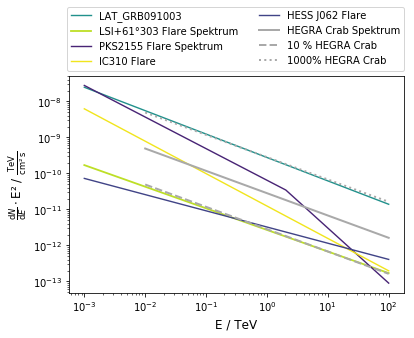

In [10]:
plot_Flux_Energy_LAT('GRB091003',-3,2,True,False,1.99,viridis5)
plt.plot(Eplot,Values_LSI*Eplot*Eplot, color=viridis1,lw=1.8,label='LSI+61°303 Flare Spektrum')
plt.plot(Eplot,Values_Flare*Eplot*Eplot, color=viridis10,lw=1.4,label='PKS2155 Flare Spektrum')
plt.plot(Eplot,Values_IC310,color=viridis0,lw=1.4,label='IC310 Flare')
plt.plot(Eplot,Values_Hess*Eplot*Eplot,color=viridis9, lw=1.4, label='HESS J062 Flare')
#plot_Sens('Tev','binwise')
plot_HEGRA_Crab(-2,2,True,'darkgrey')
plt.legend(bbox_to_anchor=(-0.02, 1.0, 1., .101),ncol=2)
plt.savefig('Plots_DE/Comparison.pdf',bbox_inches = 'tight')
#plt.savefig('Plots_DE/jpeg/Comparison.jpeg',bbox_inches = 'tight')

## Lightcurves LC 

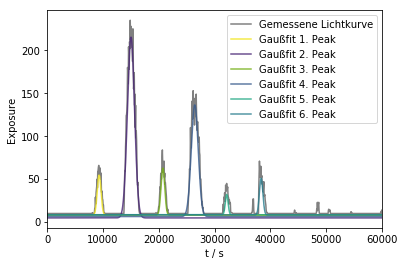

In [14]:
x,y = np.genfromtxt('DATA/LC_SOLAR/Flare20120307.txt', unpack=True)
plt.plot(x,y+10,color='grey', label='Gemessene Lichtkurve')

params, cov = curve_fit(Gauss, x,y, p0=(50,15000,100,0))
params1, cov = curve_fit(Gauss, x,y, p0=(200,10000,100,0))
params2, cov = curve_fit(Gauss, x,y, p0=(100,21000,100,0))
params3, cov = curve_fit(Gauss, x,y, p0=(150,27000,100,0))
params4, cov = curve_fit(Gauss, x,y, p0=(30,32000,100,0))
params5, cov = curve_fit(Gauss, x,y, p0=(50,38000,100,0))
xlin = np.linspace(100,84000, 1000000)

plt.plot(xlin,Gauss(xlin,*params1),color=viridis0, alpha = 0.8, label='Gaußfit 1. Peak')
plt.plot(xlin,Gauss(xlin,*params),color=viridis10, alpha = 0.8, label='Gaußfit 2. Peak')
plt.plot(xlin,Gauss(xlin,*params2),color=tugreen, alpha = 0.8, label='Gaußfit 3. Peak')
plt.plot(xlin,Gauss(xlin,*params3),color=viridis8, alpha = 0.8, label='Gaußfit 4. Peak')
plt.plot(xlin,Gauss(xlin,*params4),color=viridis4, alpha = 0.8, label='Gaußfit 5. Peak')
plt.plot(xlin,Gauss(xlin,*params5),color=viridis6, alpha = 0.8, label='Gaußfit 6. Peak')
plt.xlim(0,60000)
plt.xlabel('t / s')
plt.ylabel('Exposure')
plt.legend() ; 
#plt.savefig('Plots_DE/SolarFlares.pdf')
plt.savefig('Plots_DE/jpeg/SolarFlares.jpeg')
plt.show()

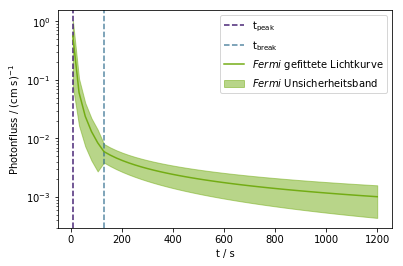

In [17]:
def Simple(t,tp,alpha,F0):
    return F0*(t/tp)**(-alpha)

@np.vectorize
def Broken(t,tb,alpha1, alpha2,F0):
    if t< tb:
        return F0*(t/tb)**(-alpha1)
    else:
        return F0*(t/tb)**(-alpha2)

plt.ylabel('Photonfluss / (cm s)$^{-1}$')
plt.xlabel('t/ s')
xlin = np.linspace(9,100)
tp = ufloat(9,1)
alpha = ufloat(1.56,0.06)
F0 = ufloat(600,100)*1e-5

Values = Simple(xlin,tp,alpha,F0)
Val = unp.nominal_values(Values)
Err = unp.std_devs(Values)
plt.axvline(9, label='t$_{\mathrm{peak}}$', ls='--', color='indigo')
plt.plot(xlin,Val, color='#73ac14', label='$Fermi$ fitted lightcurve')
plt.fill_between(xlin,Val-Err,Val+Err,color='#73ac14', lw=1, alpha=0.5, label='$Fermi$ uncertainties')
plt.yscale('log')
plt.legend()
plt.savefig('Plots_DE/Simple_Powerlaw.pdf', bbox_inches= 'tight')
#plt.savefig('Plots_DE/jpeg/Simple_Powerlaw.jpeg', bbox_inches= 'tight')
plt.clf()

plt.ylabel('Photonfluss / (cm s)$^{-1}$')
plt.xlabel('t / s')
xlin = np.linspace(9,1200)
tb = ufloat(130,50,1)
alpha1 = ufloat(1.7,0.2)
alpha2 = ufloat(0.8,0.2)
F0 = ufloat(600,100)*1e-5

Values = Broken(xlin,tb,alpha1,alpha2,F0)
Val = unp.nominal_values(Values)
Err = unp.std_devs(Values)
plt.axvline(9, label='t$_{\mathrm{peak}}$', ls='--', color=viridis10)
plt.axvline(130, label='t$_{\mathrm{break}}$', ls='--', color=viridis7, alpha=0.8)
plt.plot(xlin,Val, color='#73ac14', label='$Fermi$ gefittete Lichtkurve')
plt.fill_between(xlin,Val-Err,Val+Err,color='#73ac14', lw=1, alpha=0.5, label='$Fermi$ Unsicherheitsband')
plt.yscale('log')
plt.legend()
plt.savefig('Plots_DE/Broken_Powerlaw.pdf', bbox_inches= 'tight')
#plt.savefig('Plots_DE/jpeg/Broken_Powerlaw.jpeg', bbox_inches= 'tight')

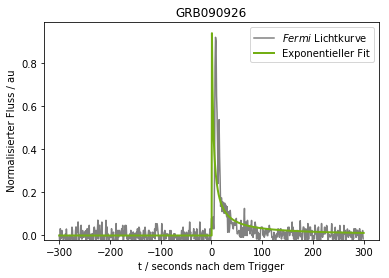

In [24]:
#reset_txt()
@np.vectorize
def Step_exp(t,tp,Fp,b ,alpha):
    if t < tp:
        return float(0)  # uniform data types 
    if t >= tp:
        return float(Fp*(t/tp-b)**(-alpha))

rescale_x('/home/jana/Schreibtisch/Projekt_Master/Project_Master/DATA/LC/LAT_090902.txt')
rescale_y('/home/jana/Schreibtisch/Projekt_Master/Project_Master/DATA/LC/LAT_090902.txt')
x,y = np.genfromtxt('/home/jana/Schreibtisch/Projekt_Master/Project_Master/DATA/LC/LAT_090902.txt', unpack=True, skip_header=1 ) ; y=y-y[0]
plt.plot(x-300,y,'-',color='grey', label='$Fermi$ Lichtkurve')
x2 =np.linspace(-300,300,1000)
y2 = Step_exp(x2,0.71,0.27,-3,0.95)/ Step_exp(0.71,0.71,0.27,-3,0.95)
plt.plot(x2,y2, color=tugreen,lw=2, label='Exponentieller Fit')
plt.legend()
plt.ylabel(r' Normalisierter Fluss / au')
plt.xlabel('t / seconds nach dem Trigger')
plt.ylim(-0.02)
plt.title('GRB090926')
#plt.savefig('Plots_DE/jpeg/Exponential.jpg')
plt.savefig('Plots_DE/Exponential.pdf')

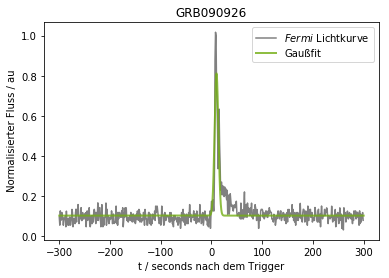

In [23]:
rescale_x('/home/jana/Schreibtisch/Projekt_Master/Project_Master/DATA/LC/LAT_090902.txt')
rescale_y('/home/jana/Schreibtisch/Projekt_Master/Project_Master/DATA/LC/LAT_090902.txt')
x,y = np.genfromtxt('/home/jana/Schreibtisch/Projekt_Master/Project_Master/DATA/LC/LAT_090902.txt', unpack=True, skip_header=1 )
A0 = y.max() ; index = np.argmax(y)
mu0 = x[index] ## Mitte / Peak, ab hier -1 für exp. Fit
y = y+abs(y.min())+1e-3

plt.plot(x-300,y,'-',color='grey', label='$Fermi$ Lichtkurve')
params, cov = curve_fit(Gauss, x,y,p0=(2,mu0,5,0)) ;  errors = np.sqrt(np.diag(cov))
xlin = np.linspace(0,600, 10000)
plt.plot(xlin-300,Gauss(xlin,*params),color=tugreen,lw=2, alpha = 0.8, label='Gaußfit')

plt.ylabel(r' Normalisierter Fluss / au')
plt.xlabel('t / seconds nach dem Trigger')
plt.legend() ;
plt.title('GRB090926')
#plt.savefig('Plots_DE/Simple_Gauss.pdf')
plt.savefig('Plots_DE/jpeg/Simple_Gauss.jpeg')
plt.show()

10

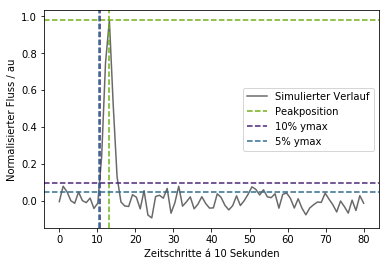

In [29]:
def Gauss_Norm(x, x0, sigma,b):
    return np.exp(-(x-x0)**2/(2*sigma**2))+b
def x_from_y_Gauss(percentage,y,sigma,mu):
    return -np.sqrt(2*np.log(1/(percentage*y)))*sigma+mu

def simulate_Gaussians(sigma_range_min,sigma_range_max,Num_slices,time_per_slice):
    time = Num_slices*time_per_slice 
    '''
    Rescale sigmas to given time & randomply drag a float sigma value 
    '''
    sigma_range_min_time = sigma_range_min/(600)*time 
    sigma_range_max_time = sigma_range_max/(600)*time 
    sigma = uniform(sigma_range_min_time,sigma_range_max_time)

    '''
    Adjust possible positions for the peak: mu 
    Start with 3 slices + 1 sigma before peak 
    End with 3 sliced and 1 sigma after peak 
    '''
    mu_min = sigma_range_max_time+time_per_slice*3
    mu_max = Num_slices*time_per_slice -3*time_per_slice -sigma_range_max_time
    mu = uniform(mu_min,mu_max)

    '''
    Calculate #N_slices values, normal distributed around random mu and sigma 
    '''
    xlin = np.linspace(0,time,Num_slices)
    ylin = Gauss_Norm(xlin,mu,sigma,0)
    y = ylin.max() 
    ylin = ylin/y
    noise = np.random.normal(0,0.04, ylin.shape)
    ylin = ylin + noise
    
    
    plt.plot(xlin/time_per_slice ,ylin,'-', color='dimgray',label='Simulierter Verlauf')
    plt.axvline(mu/time_per_slice ,linestyle='--', color=tugreen, label='Peakposition')
    plt.axhline(ylin.max(),linestyle='--', color=tugreen)
    plt.axvline(x_from_y_Gauss(0.1,y,sigma,mu)/time_per_slice , linestyle='--', color=viridis10,label='10% ymax')
    plt.axhline(0.1*ylin.max(),linestyle='--', color=viridis10,)

    plt.axvline(x_from_y_Gauss(0.05,y,sigma,mu)/time_per_slice, linestyle='--', color=viridis7,label='5% ymax')
    plt.axhline(0.05*ylin.max(),linestyle='--', color=viridis7)
    True_Start = int(x_from_y_Gauss(0.05,y,sigma,mu)/time_per_slice) # Number of slice 
    
    plt.legend()
    #plt.xlim(20,40)
    plt.xlabel('Zeitschritte á 10 Sekunden')
    plt.ylabel('Normalisierter Fluss / au')
    return ylin, True_Start
    
    
y,True_Start = simulate_Gaussians(1.8348,16.0364,80,10)
plt.savefig('Plots_DE/New_Results_21.pdf')
#plt.savefig('Plots_DE/jpeg/New_Results_21.jpeg')

True_Start   ## +/- 2 Slices Toleranz 

0

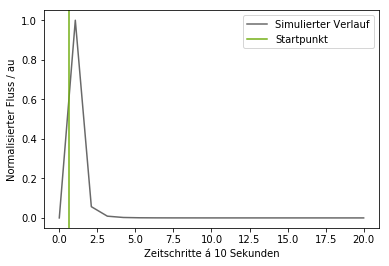

In [36]:
@np.vectorize
def Step_exp(t,tp,Fp,b ,alpha):
    if t < tp:
        return float(0)  # uniform data types 
    if t >= tp:
        return float(Fp*(t/tp+b)**(-alpha))

alpha_min = 3
b_min = 0
alpha_max = 6
b_max = 2

def simulate_Exponential(alpha_min,alpha_max,b_min,b_max,Num_slices,time_per_slice):
    time = Num_slices*time_per_slice 
    alpha_min_time = alpha_min
    b_min_time = b_min/600*time
    alpha_max_time = alpha_max
    b_max_time = b_max/600*time
    
    b = uniform(b_min_time,b_max_time)
    alpha = uniform(alpha_min_time, alpha_max_time)
    tp = uniform(0,time/3)
    params = np.array([tp,1,b,alpha])

    x2 =np.linspace(0,time,Num_slices)
    y2 = Step_exp(x2,params[0], params[1], params[2], params[3])
    y2 = y2/y2.max()
    noise = np.random.normal(0,0.00, y2.shape)
    y2 = y2 + noise
    
    plt.plot(x2/time_per_slice,y2, color='dimgray',label='Simulierter Verlauf')
    plt.axvline(tp/time_per_slice,color=tugreen, label='Startpunkt')
    plt.xlabel('Zeitschritte á 10 Sekunden')
    plt.ylabel('Normalisierter Fluss / au')
    plt.legend()
    True_Start = tp/time_per_slice
    return y2,int(True_Start)

y,True_Start = simulate_Exponential(alpha_min,alpha_max,b_min,b_max,20,100)
#plt.savefig('Plots_DE/New_Results_20.pdf')
plt.savefig('Plots_DE/jpeg/New_Results_20.jpeg')
True_Start

## Expectation calculations 

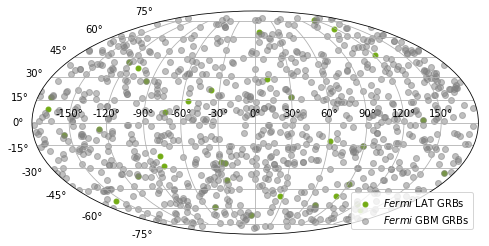

In [38]:
'''
Isotropic density due to extragalactic origin 
'''
### Isotropie aus Katalog plotten und zeigen 
Datei = fits.open('Kataloge/LATGRB.fits',ignore_missing_end=True)
Kat = Datei['FermiLGRB']
Ra = Kat.data['RA']
Dec = Kat.data['DEC']
import astropy.coordinates as coord
ra = coord.Angle(Ra*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(Dec*u.degree)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.grid(True)
ax.scatter(ra.radian, dec.radian, color='#73ac14',s=24, label='$Fermi$ LAT GRBs')

Datei = fits.open('Kataloge/GRBST.fits',ignore_missing_end=True)
Kat = Datei['FERMIGBRST']
Ra = Kat.data['RA']
Dec = Kat.data['DEC']
import astropy.coordinates as coord
ra = coord.Angle(Ra*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(Dec*u.degree)
ax.scatter(ra.radian, dec.radian, color='grey',alpha=0.5, label='$Fermi$ GBM GRBs')
plt.legend(loc='lower right')
plt.savefig('Plots_DE/Isotropy.pdf')
#plt.savefig('Plots_DE/jpeg/Isotropy.jpeg')

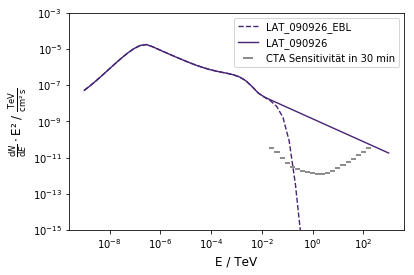

In [42]:
from Gilmore_simulation import simulate_BATSE_detection, simulate_GBM_detection, simulate_LAT_detection 
simulate_LAT_detection('/home/jana/Schreibtisch/Projekt_Master/caldb/data/cta/prod3b/bcf/South_z20_average_30m/irf_file.fits',
                       '090926',1800,4)
#plt.savefig('Plots_DE/Gilmore_Example.pdf',bbox_inches = 'tight')
plt.savefig('Plots_DE/jpeg/Gilmore_Example.jpeg',bbox_inches = 'tight')
plt.show()

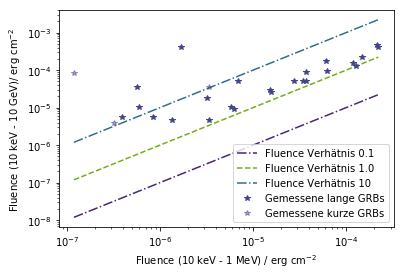

In [46]:
DF = make_DF_from_GBM('Kataloge/GRBST.fits')
LAT_DF = make_DF_from_LGRB('Kataloge/LATGRB.fits')
GBM_Flu = np.zeros(26) ; Flu_LAT = np.zeros(26)
Fast_GBM = np.zeros(4) ; Fast_LAT = np.zeros(4)
index, index2 = 0,0

for i in LAT_DF['Name']:
    LAT = LAT_DF[LAT_DF.Name.str.contains(i)]
    Table = DF[DF.Name.str.contains(i[0:9])]
    if len(Table) == 1:  
        
        if Table['T90/s'].iloc[0] > 2: 
            GBM_Flu[index] = Table['Fluence'].iloc[0]
            Flu_LAT[index] = LAT['Fluence']
            index +=1
        else:
            Fast_GBM[index2] = Table['Fluence'].iloc[0]
            Fast_LAT[index2] = LAT['Fluence']
            index2 +=1 
    if len(Table) == 2:
        if Table['T90/s'].iloc[0] > 2: 
            GBM_Flu[index] = Table['Fluence'].iloc[0]
            Flu_LAT[index] = LAT['Fluence']
            index +=1
        if Table['T90/s'].iloc[1] > 2: 
            GBM_Flu[index] = Table['Fluence'].iloc[1]
            Flu_LAT[index] = LAT['Fluence']
            index +=1
        if Table['T90/s'].iloc[0] <= 2:
            Fast_GBM[index2] = Table['Fluence'].iloc[0]
            Fast_LAT[index2] = LAT['Fluence'] 
            index2 +=1
        if Table['T90/s'].iloc[1] <= 2:
            Fast_GBM[index2] = Table['Fluence'].iloc[1]
            Fast_LAT[index2] = LAT['Fluence'] 
            index2 +=1 
            
plt.xlabel('Fluence (10 keV - 1 MeV) / erg cm$^{-2}$') 
plt.ylabel('Fluence (10 keV - 10 GeV)/ erg cm$^{-2}$') 
plt.xscale('log') ; plt.yscale('log')
x = np.linspace(Fast_GBM.min(),GBM_Flu.max())
plt.plot(x,0.1*x,'-.',color=viridis10,label='Fluence Verhätnis 0.1')
plt.plot(x,x,'--',color=tugreen,label='Fluence Verhätnis 1.0')
plt.plot(x,10*x,'-.',color=viridis7,label='Fluence Verhätnis 10')
plt.plot(GBM_Flu,Flu_LAT,'*',color=viridis9,label='Gemessene lange GRBs')
plt.plot(Fast_GBM,Fast_LAT,'*',color=viridis9,alpha=0.5,label='Gemessene kurze GRBs')
plt.legend()
plt.savefig('Plots_DE/LAT_GBM_Fluence.pdf',bbox_inches='tight')
#plt.savefig('Plots_DE/jpeg/LAT_GBM_Fluence.jpg',bbox_inches='tight')

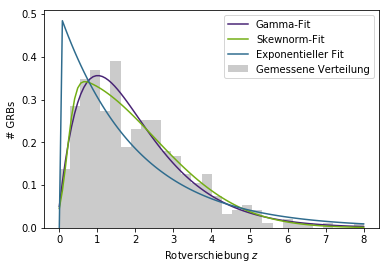

2.0820486455090523

In [49]:
## Redshifts
Name,Flu,z = np.genfromtxt('Kataloge/SWIFT.txt',unpack=True)
Flu = Flu*1e-7 # in erg/cm² between 15 and 150 keV 
## Redshift 
plt.hist(z[z>0],bins=30,color='darkgray',density=True, alpha=0.6, label = 'Gemessene Verteilung')
plt.xlabel('Rotverschiebung $z$') ; plt.ylabel('# GRBs')

gamma = stats.gamma
x = np.linspace(0, z[z>0].max(), 100)
param = gamma.fit(z[z>0]) ; pdf_fitted = gamma.pdf(x, *param)
a = param[0]
plt.plot(x, pdf_fitted, color=viridis10, label='Gamma-Fit')

skewnorm = stats.skewnorm
param = skewnorm.fit(z[z>0]) ; pdf_fitted = skewnorm.pdf(x, *param)
plt.plot(x, pdf_fitted, color=tugreen, label='Skewnorm-Fit')

P = stats.expon.fit(z[z>0])
rX = np.linspace(0,8, 100) ; rP = stats.expon.pdf(rX, *P)
plt.plot(rX, rP, color=viridis7, label='Exponentieller Fit')
plt.legend()
#plt.savefig('Plots_DE/SWIFT_Redshifts.pdf',bbox_inches='tight')
plt.savefig('Plots_DE/jpeg/SWIFT_Redshifts.jpg',bbox_inches='tight')
plt.show() ; plt.clf()
## Test density 
r = gamma.rvs(a, size=1000)
a

Length of Lowest regime (0-1.2) =  118
Length of Middle regime (1.2-2.43)=  119
Length of Highest regime (>2.43) =  119
The higher the redshfit, the higher the fluence needed for a detection


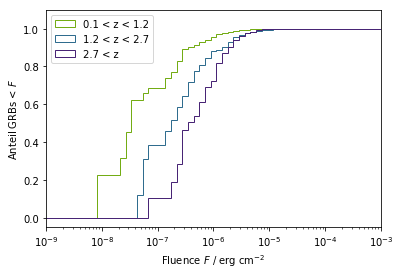

Pearson correlation Redshift to Fluence:  -0.119884970133


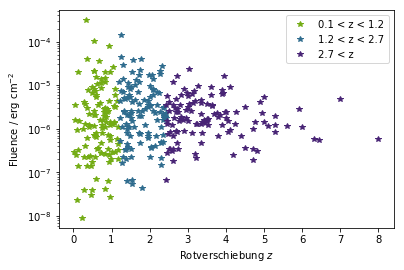

In [50]:
SWIFT_DF = pd.DataFrame({'Name': Name,'Fluence':Flu , 'Redshift': z   })
All_z = SWIFT_DF[SWIFT_DF['Redshift']>0]
Low_z = All_z[All_z['Redshift']<1.2]
Config_z = All_z[All_z['Redshift']>1.2]
Mid_z = Config_z[Config_z['Redshift']<2.43]
High_z = All_z[All_z['Redshift']>2.43]
# Rates
print('Length of Lowest regime (0-1.2) = ',len(Low_z['Redshift']))
print('Length of Middle regime (1.2-2.43)= ',len(Mid_z['Redshift']))
print('Length of Highest regime (>2.43) = ',len(High_z['Redshift']))
# Histogramm 
binning = np.logspace(-9,-3,60)
plt.hist(Low_z['Fluence'],histtype = 'step',cumulative=True, bins=binning,density=True,
        color='#73ac14', label='0.1 < z < 1.2')
plt.hist(Mid_z['Fluence'],histtype = 'step',cumulative=True,bins=binning, density=True,
        color=viridis7, label='1.2 < z < 2.7')
plt.hist(High_z['Fluence'],histtype='step',cumulative=True,bins=binning,density=True,
        color=viridis10, label='2.7 < z')

print('The higher the redshfit, the higher the fluence needed for a detection')

plt.xscale('log')
plt.ylim(-0.05,1.1) ; plt.xlim(1e-9,1e-3)
plt.xlabel('Fluence $F$ / erg cm$^{-2}$') ; plt.ylabel('Anteil GRBs < $F$')
plt.legend(loc ='upper left')
plt.savefig('Plots_DE/SWIFT_z_Fluence.pdf',bbox_inches='tight') ;plt.show(); plt.clf()
#plt.savefig('Plots_DE/jpeg/SWIFT_z_Fluence.jpg',bbox_inches='tight') ; plt.show(); plt.clf()


plt.plot(Low_z['Redshift'],Low_z['Fluence'],'*', color='#73ac14',label='0.1 < z < 1.2')
plt.plot(Mid_z['Redshift'],Mid_z['Fluence'],'*', color=viridis7,label='1.2 < z < 2.7')
plt.plot(High_z['Redshift'],High_z['Fluence'],'*', color=viridis10,label='2.7 < z ')

plt.yscale('log')
plt.legend()
plt.xlabel('Rotverschiebung $z$') ; plt.ylabel('Fluence / erg cm$^{-2}$')
plt.savefig('Plots_DE/SWIFT_z_Fluence_Corr.pdf',bbox_inches='tight') 
#plt.savefig('Plots_DE/jpeg/SWIFT_z_Fluence_Corr.jpg',bbox_inches='tight') ; plt.show() ; plt.clf()
print('Pearson correlation Redshift to Fluence: ',
      scipy.stats.pearsonr(All_z['Redshift'],All_z['Fluence'])[0]) #Pearson coefficient and p-Value 

## EBL Modell

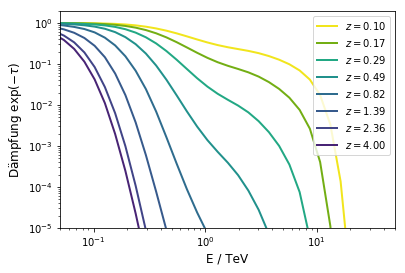

In [51]:
## New EBL method 
colors = np.array(['indigo', 'dimgray','thistle','darkslateblue','lightsteelblue',
                  'darkmagenta','lightgray','midnightblue'])

colors = np.array([viridis0,tugreen,viridis4,viridis5,viridis7,viridis8,viridis9,viridis10])

from ebltable.tau_from_model import OptDepth
tau =  OptDepth.readmodel(model = 'dominguez')
z = np.arange(0.1,4,0.45)
z = np.logspace(np.log10(0.1), np.log10(4), num=8)
ETeV = np.logspace(-2,2.5,50)
atten = np.exp(-1. * tau.opt_depth(z,ETeV))
for i,zz in enumerate(z):
    plt.loglog(ETeV,atten[i],
              ls = '-',color = colors[i],
              label = '$z = {0:.2f}$'.format(zz), lw = 2)

plt.gca().set_ylim((1e-5,2.))
plt.gca().set_xlim((5e-2,5e1))
plt.gca().set_xlabel('E / TeV',size = 'large')
plt.gca().set_ylabel(r'Dämpfung $\exp(-\tau)$',size = 'large')
plt.legend(loc = 'upper right')
#plt.savefig('Plots_DE/jpeg/New_EBL_Dom.jpg')
plt.savefig('Plots_DE/New_EBL_Dom.pdf')
plt.show()

## MST Calculations 

In [52]:
'''
MAGIC Effective Area and Background (Performance paper 2014)
'''
E_SensDiff_low = np.array([63.1,100,158,251,398,631,1000,1580,2510,3980,6310])*u.GeV
E_SensDiff_up =  np.array([100,158,251,398,631,1000,1580,2510,3980,6310,10000])*u.GeV
E_SensDiff  = (E_SensDiff_up+E_SensDiff_low)/2
E_SensDiff_Length = E_SensDiff-E_SensDiff_low
Zenith = 'medium'
if Zenith == 'low' :
    A = np.array([1.244,1.9732,3.067,2.497,4.494,6.505,8.591,8.909,9.888,11.094,14.35251])
    Nbackt  = np.array([4.06,2.41,0.54,0.066,0.027,0.0133,0.0059,0.0027,0.0020,0.0014,0.0046])/u.min
if Zenith == 'medium':
    A = np.array([0.16529681,1.46266036,2.43023741,5.25106048,6.48342453,10.64483946,13.92425647,19.89855896,
                  19.05061758,23.85890173,23.92085088])
    Nbackt  = np.array([2.92,2.89,0.54,0.305,0.088,0.038,0.0197,0.0111,0.0093,0.0042,0.0052])/u.min
Aeff = A*10**8*u.cm*u.cm
Energy_Aeff = np.array([81.5,129,204.5,324.5,514,815,1292.5,2048,3246.5,5145.5,8155])*u.GeV

'''
VERITAS 
Aeff in Array read out from picture
'''
E_array_Veritas = ([-1.28,-1.14,-1.09,-0.98,-0.88,-0.74,-0.655,-0.58,-0.49,-0.335,-0.25,-0.16,-0.07, # Alle negativen 
           0.035,0.115,0.255,0.34,0.44,0.56,0.65,0.74,0.85,0.92,1.04,1.12,1.24,1.36,1.49,
           1.57,1.66,1.755,1.855,1.94])

@np.vectorize
def Zehner(E):
    return 10**E

E_array_Veritas = Zehner(E_array_Veritas)
A_array_Veritas= np.array([3.3,27,290,2000,8800,21300,27000,39000,50000,68000,72000,78000,85000,
          86000,86500,87000,87000,88000,89000,85000,86000,90000,83000,
          83000,89500,78000,90000,80000,82000,66000,52000,40000,20000])



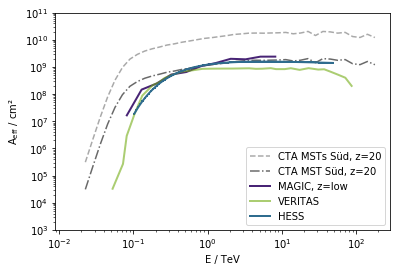

In [55]:
energy = np.logspace(-1, 1.7, 100) * u.TeV
from gammapy.irf import EffectiveAreaTable


cta_perf_fits = fits.open('/home/jana/Schreibtisch/Projekt_Master/MST_Ring_Calculations/Data_sheets/caldb/data/cta/prod3b/bcf/South_z20_average_MST_30m/irf_file.fits')
data_A_eff = cta_perf_fits['EFFECTIVE AREA']
a_eff_cta_south = OrderedDict({"E_TeV": (data_A_eff.data['ENERG_LO'][0] + data_A_eff.data['ENERG_HI'][0])/2,
                                "A_eff": data_A_eff.data['EFFAREA'][0]})
p2, = plt.plot(a_eff_cta_south['E_TeV'], a_eff_cta_south['A_eff'][0]*1e4,'--',color='darkgray', label='CTA MSTs Süd, z=20')
p4, = plt.plot(a_eff_cta_south['E_TeV'], a_eff_cta_south['A_eff'][0]*1e4*0.1,'-.',color='dimgray', label='CTA MST Süd, z=20')

p1, = plt.plot(E_SensDiff.value*1e-3, Aeff.value,lw=2, label='MAGIC, z=low', color=viridis10)
aeff_Hess = EffectiveAreaTable.from_parametrization(energy, 'HESS')
aeff_Hess.plot(label='HESS',color=viridis7)
p3, = plt.plot(E_array_Veritas,A_array_Veritas*1e4,'-',lw=2,color='#73ac14',alpha=0.6 ,label='VERITAS')


plt.yscale('log')
plt.ylabel('A$_{\mathrm{eff}}$ / cm²')
plt.xlabel('E / TeV')
plt.ylim(1e3,1e11)
plt.legend()
#plt.savefig('Plots_DE/All_telescopes.pdf',bbox_inches = 'tight')
plt.savefig('Plots_DE/jpeg/All_telescopes.jpeg',bbox_inches = 'tight')